TODO :

definir un modèle probabiliste "conditionnel" hiérarchique

et le tester en premier avec info complete (tous les pixels)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [14]:
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32, WaveDict

In [4]:
import math

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### Ajout des bords

In [6]:
image = mnist_reshape_32(mnist.train.images[0])

#### insertion de quatre points (avec leur descendance)

In [7]:
#image = image[:3,:]
w1 = WaveImage()
w2 = WaveImage(image = image)
w1.add_coeffs(w2, u = (15, 15), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (15, 17), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (17, 15), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (17, 17), h_ref = w2.get_h_max())


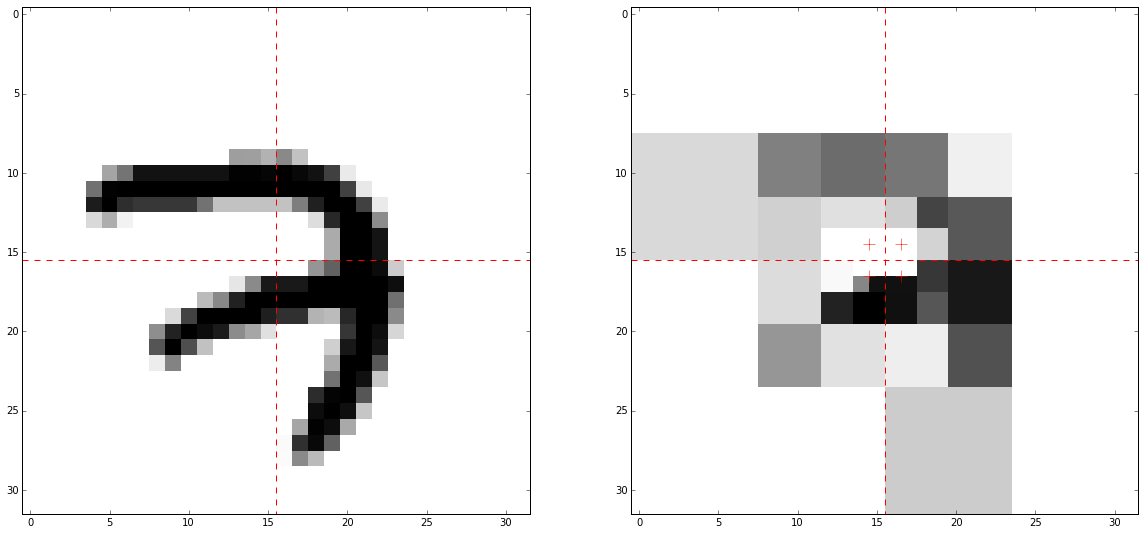

In [8]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(w2.get_image(), cmap = 'gray_r', interpolation = 'nearest')
plt.plot([-0.5, 31.5],[15.5, 15.5],'r--')
plt.plot([15.5, 15.5],[-0.5, 31.5],'r--')
plt.xlim([-0.5, 31.5])
plt.ylim([-0.5, 31.5])
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(w1.get_image(), cmap = 'gray_r', interpolation = 'nearest')
plt.plot([-0.5, 31.5],[15.5, 15.5],'r--')
plt.plot([15.5, 15.5],[-0.5, 31.5],'r--')
plt.plot(15 - .5, 15 - .5, 'r+', markersize = 12)
plt.plot(15 - .5, 17 - .5, 'r+', markersize = 12)
plt.plot(17 - .5, 15 - .5, 'r+', markersize = 12)
plt.plot(17 - .5, 17 - .5, 'r+', markersize = 12)
plt.xlim([-0.5, 31.5])
plt.ylim([-0.5, 31.5])
plt.gca().invert_yaxis()

#### Test de la fonction de copie

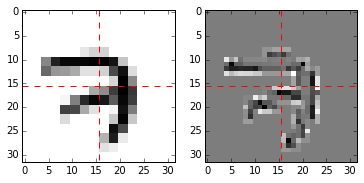

In [9]:
w3 = w2.copy()

h_max = w3.get_h_max()
data =  w3.get_data()
h_ref = h_max - 1
for u in data[h_ref]:
    w3.set_data(h_ref, u, np.zeros(3))

plt.subplot(1,2,1)
plt.imshow(w3.get_image(), cmap = 'gray_r', interpolation = 'nearest')
plt.plot([-0.5, 31.5],[15.5, 15.5],'r--')
plt.plot([15.5, 15.5],[-0.5, 31.5],'r--')
plt.xlim([-0.5, 31.5])
plt.ylim([-0.5, 31.5])
plt.gca().invert_yaxis()

w3 = w2.copy()
data =  w3.get_data()

for u in data[0]:
    w3.set_data(0, u, 0)
for h in range(1,h_ref):
    for u in data[h]: 
        w3.set_data(h, u, np.zeros(3))
        
plt.subplot(1,2,2)
plt.imshow(w3.get_image(), cmap = 'gray_r', interpolation = 'nearest')
plt.plot([-0.5, 31.5],[15.5, 15.5],'r--')
plt.plot([15.5, 15.5],[-0.5, 31.5],'r--')
plt.xlim([-0.5, 31.5])
plt.ylim([-0.5, 31.5])
plt.gca().invert_yaxis()


#### Base d'apprentissage

In [10]:
B_app = []
for i in range(len(mnist.train.images)):
    if i % 1000 == 0 :
        print i
    c = mnist.train.labels[i]
    image =  mnist_reshape_32(mnist.train.images[i])
    B_app += [(WaveImage(image = image), c)]
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000


#### Base de test

In [11]:
B_test = []
for i in range(len(mnist.test.images)):
    if i % 1000 == 0 :
        print i
    c = mnist.test.labels[i]
    image =  mnist_reshape_32(mnist.test.images[i])
    B_test += [(WaveImage(image = image), c)]
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


## Dictionnaire (Base d'apprentissage)

In [53]:
class WaveDict:
	def __init__(self, shape = (32, 32), nb_classes = 10):
		# Attribut shape
		self.__shape = shape	
		# Attribut h_max : profondeur de l'image
		self.__h_max = min(int(math.log(self.__shape[0], 2)) + 1, 	int(math.log(self.__shape[1], 2)) + 1)
		# Attribut data : L'attribut data contient les vecteurs en position [c][h][u] (dictionnaire)
		self.__data = {}
		for c in range(nb_classes):
			self.__data[c] = {}
			for h in range(self.__h_max):
				self.__data[c][h] = {}
				dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
				for i in range(dim_i):
					for j in range(dim_j):
						self.__data[c][h][(i, j)] = []
		self.__nb_classes = nb_classes
						
	def get_shape(self):
		return self.__shape
	
	def get_h_max(self):
		return self.__h_max
		
	def get_data(self):
		return self.__data
		
	def append(self, c, h, u, v):
		assert 0 <= c < self.__nb_classes
		assert 0 <= h < self.__h_max
		if u in self.__data[c][h]:
			self.__data[c][h][u] += [v]
		else:
			self.__data[c][h][u] = [v]

	def add(self, (waveImage, c)):
		data = waveImage.get_data()
		for h in range(waveImage.get_h_max()):
			for u in calc_U((32, 32), h, waveImage.get_h_max()):
			#for u in calc_U(waveImage.get_shape(), h, waveImage.get_h_max()):
				self.append(c, h, u, data[h][u])

In [54]:
waveDict_app = WaveDict(shape = (32, 32), nb_classes = 10)
for sample in B_app:
    waveDict_app.add(sample)

In [42]:
sample[1]

7

In [39]:
calc_U((32, 32), h, 6)

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7)]

In [40]:
h

4